**Exponentially Weighted Average (EWA)**

- **EWA** smooths timeseries considering both past and recent data.
- **Alpha ($\alpha$)**: Smoothing parameter that controls the weight on recent data. If high, more weight to recent data, and if low then more weight to past data.
- **Formula**:  
  - $V_t = \alpha \cdot X_t + (1 - \alpha) \cdot V_{t-1}$  
    - $V_t$: Smoothed value at time $t$
    - $X_t$: Actual value at time $t$
    - $V_{t-1}$: Previous smoothed value 
- **Alpha ($\alpha$)**: Ranges from 0 (no smoothing) to 1 (no past data used).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

np.random.seed(47); plt.style.use('dark_background')

def calculate_ewa(series, alpha):
    """
    Calculate the Exponentially Weighted Average (EWA) of 
    a time series.
    """
    ewa = np.zeros_like(series)
    ewa[0] = series[0]

    for t in range(1, len(series)): 
        ewa[t] = alpha * series[t] + (1 - alpha) * ewa[t - 1]
    return ewa

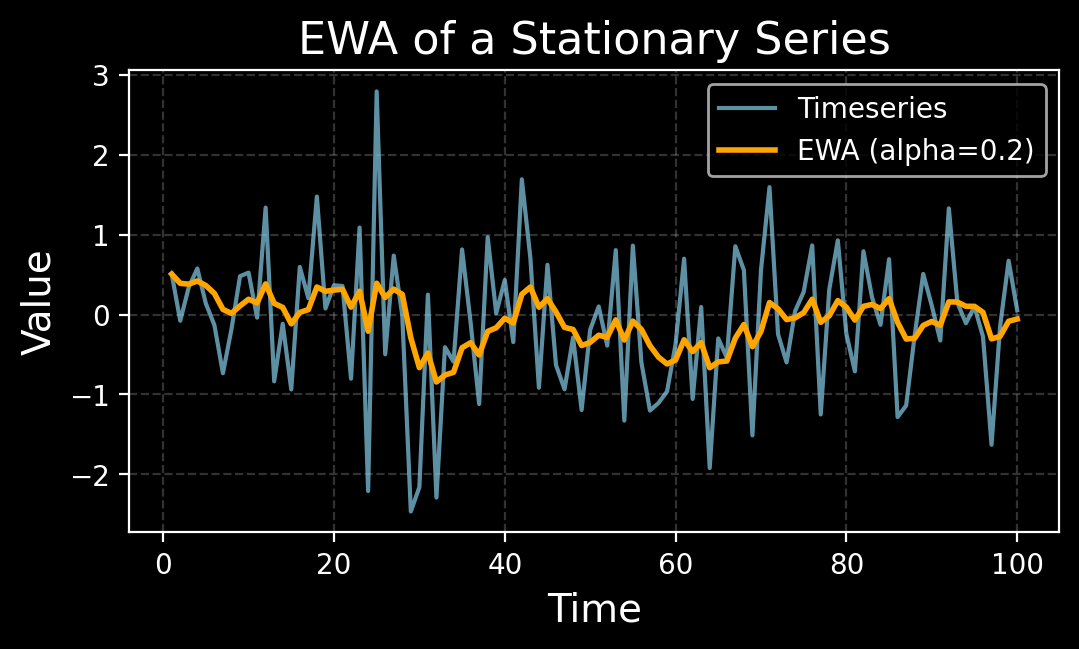

In [5]:
# Simulation
n = 100; t = np.arange(n); mean = 0; std = 1; alpha = 0.2
timeseries = np.random.normal(mean, std, n)
ewa_series = calculate_ewa(timeseries, alpha)

plt.figure(figsize=(6, 3), dpi=200)
plt.plot(range(1, n + 1), timeseries, label="Timeseries", 
         color='skyblue', alpha=0.7)
plt.plot(range(1, n + 1), ewa_series, label=f'EWA (alpha={alpha})', 
         color='orange', linewidth=2)
plt.title("EWA of a Stationary Series", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

### **Exponential Smoothing Methods for Forecasting**

1. **Single Exponential Smoothing (SES)**  
   - **Assumptions**: No trend or seasonality.  
   - **Formula**:  
     $$
     L_t = \alpha Y_t + (1 - \alpha) L_{t-1}
     $$  
   - **Forecast**:  
     $$
     \hat{Y}_{t+h} = L_t
     $$

2. **Double Exponential Smoothing (DES)**  
   - **Assumptions**: Linear trend, no seasonality.  
   - **Formula**:  
     $$
     L_t = \alpha Y_t + (1 - \alpha)(L_{t-1} + T_{t-1}), 
     $$  
     $$
     T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}
     $$  
   - **Forecast**:  
     $$
     \hat{Y}_{t+h} = L_t + h T_t
     $$

3. **Triple Exponential Smoothing (Holt-Winters)**  
   - **Assumptions**: Linear trend and seasonality.  
   - **Formula (additive seasonality)**:  
     $$
     L_t = \alpha (Y_t - S_{t-m}) + (1 - \alpha)(L_{t-1} + T_{t-1}), 
     $$  
     $$
     T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}, 
     $$  
     $$
     S_t = \gamma (Y_t - L_t) + (1 - \gamma) S_{t-m}
     $$  
   - **Forecast**:  
     $$
     \hat{Y}_{t+h} = L_t + h T_t + S_{t-m+h}
     $$

---

### **Key Terms:**

- **$L_t$ (Level)**: Smoothed value of the series at time $t$.
- **$T_t$ (Trend)**: Slope or growth/decline at time $t$.
- **$S_t$ (Seasonality)**: Seasonal component at time $t$.
- **$Y_t$ (Observed value)**: Actual value at time $t$.
- **$\alpha$**: Level smoothing constant (0 to 1).
- **$\beta$**: Trend smoothing constant (0 to 1).
- **$\gamma$**: Seasonality smoothing constant (0 to 1).
- **$m$**: Seasonal period length.
- **$h$**: Forecast horizon.
- **$\hat{Y}_{t+h}$**: Forecasted value at time $t+h$.


In [3]:
# Generate data (1 month with daily data, weekly seasonality)
n = 30 
periods = 7  # weekly seasonality
trend_slope = 0.5  
seasonality_amplitude = 3  

date_range = pd.date_range(start='2024-11-01', periods=n, freq='D')

trend = trend_slope * np.arange(n)
seasonality = (
    seasonality_amplitude * np.sin(2 * np.pi * np.arange(n)/periods)
)
noise = np.random.normal(0, 1, size=n)

data = trend + seasonality + noise

df = pd.DataFrame({
    'date': date_range, 
    'value': data
})

df.sample(5)

,date,value
11,2024-11-12,4.158256
12,2024-11-13,2.242743
16,2024-11-17,11.735523
8,2024-11-09,6.234073
21,2024-11-22,12.813517


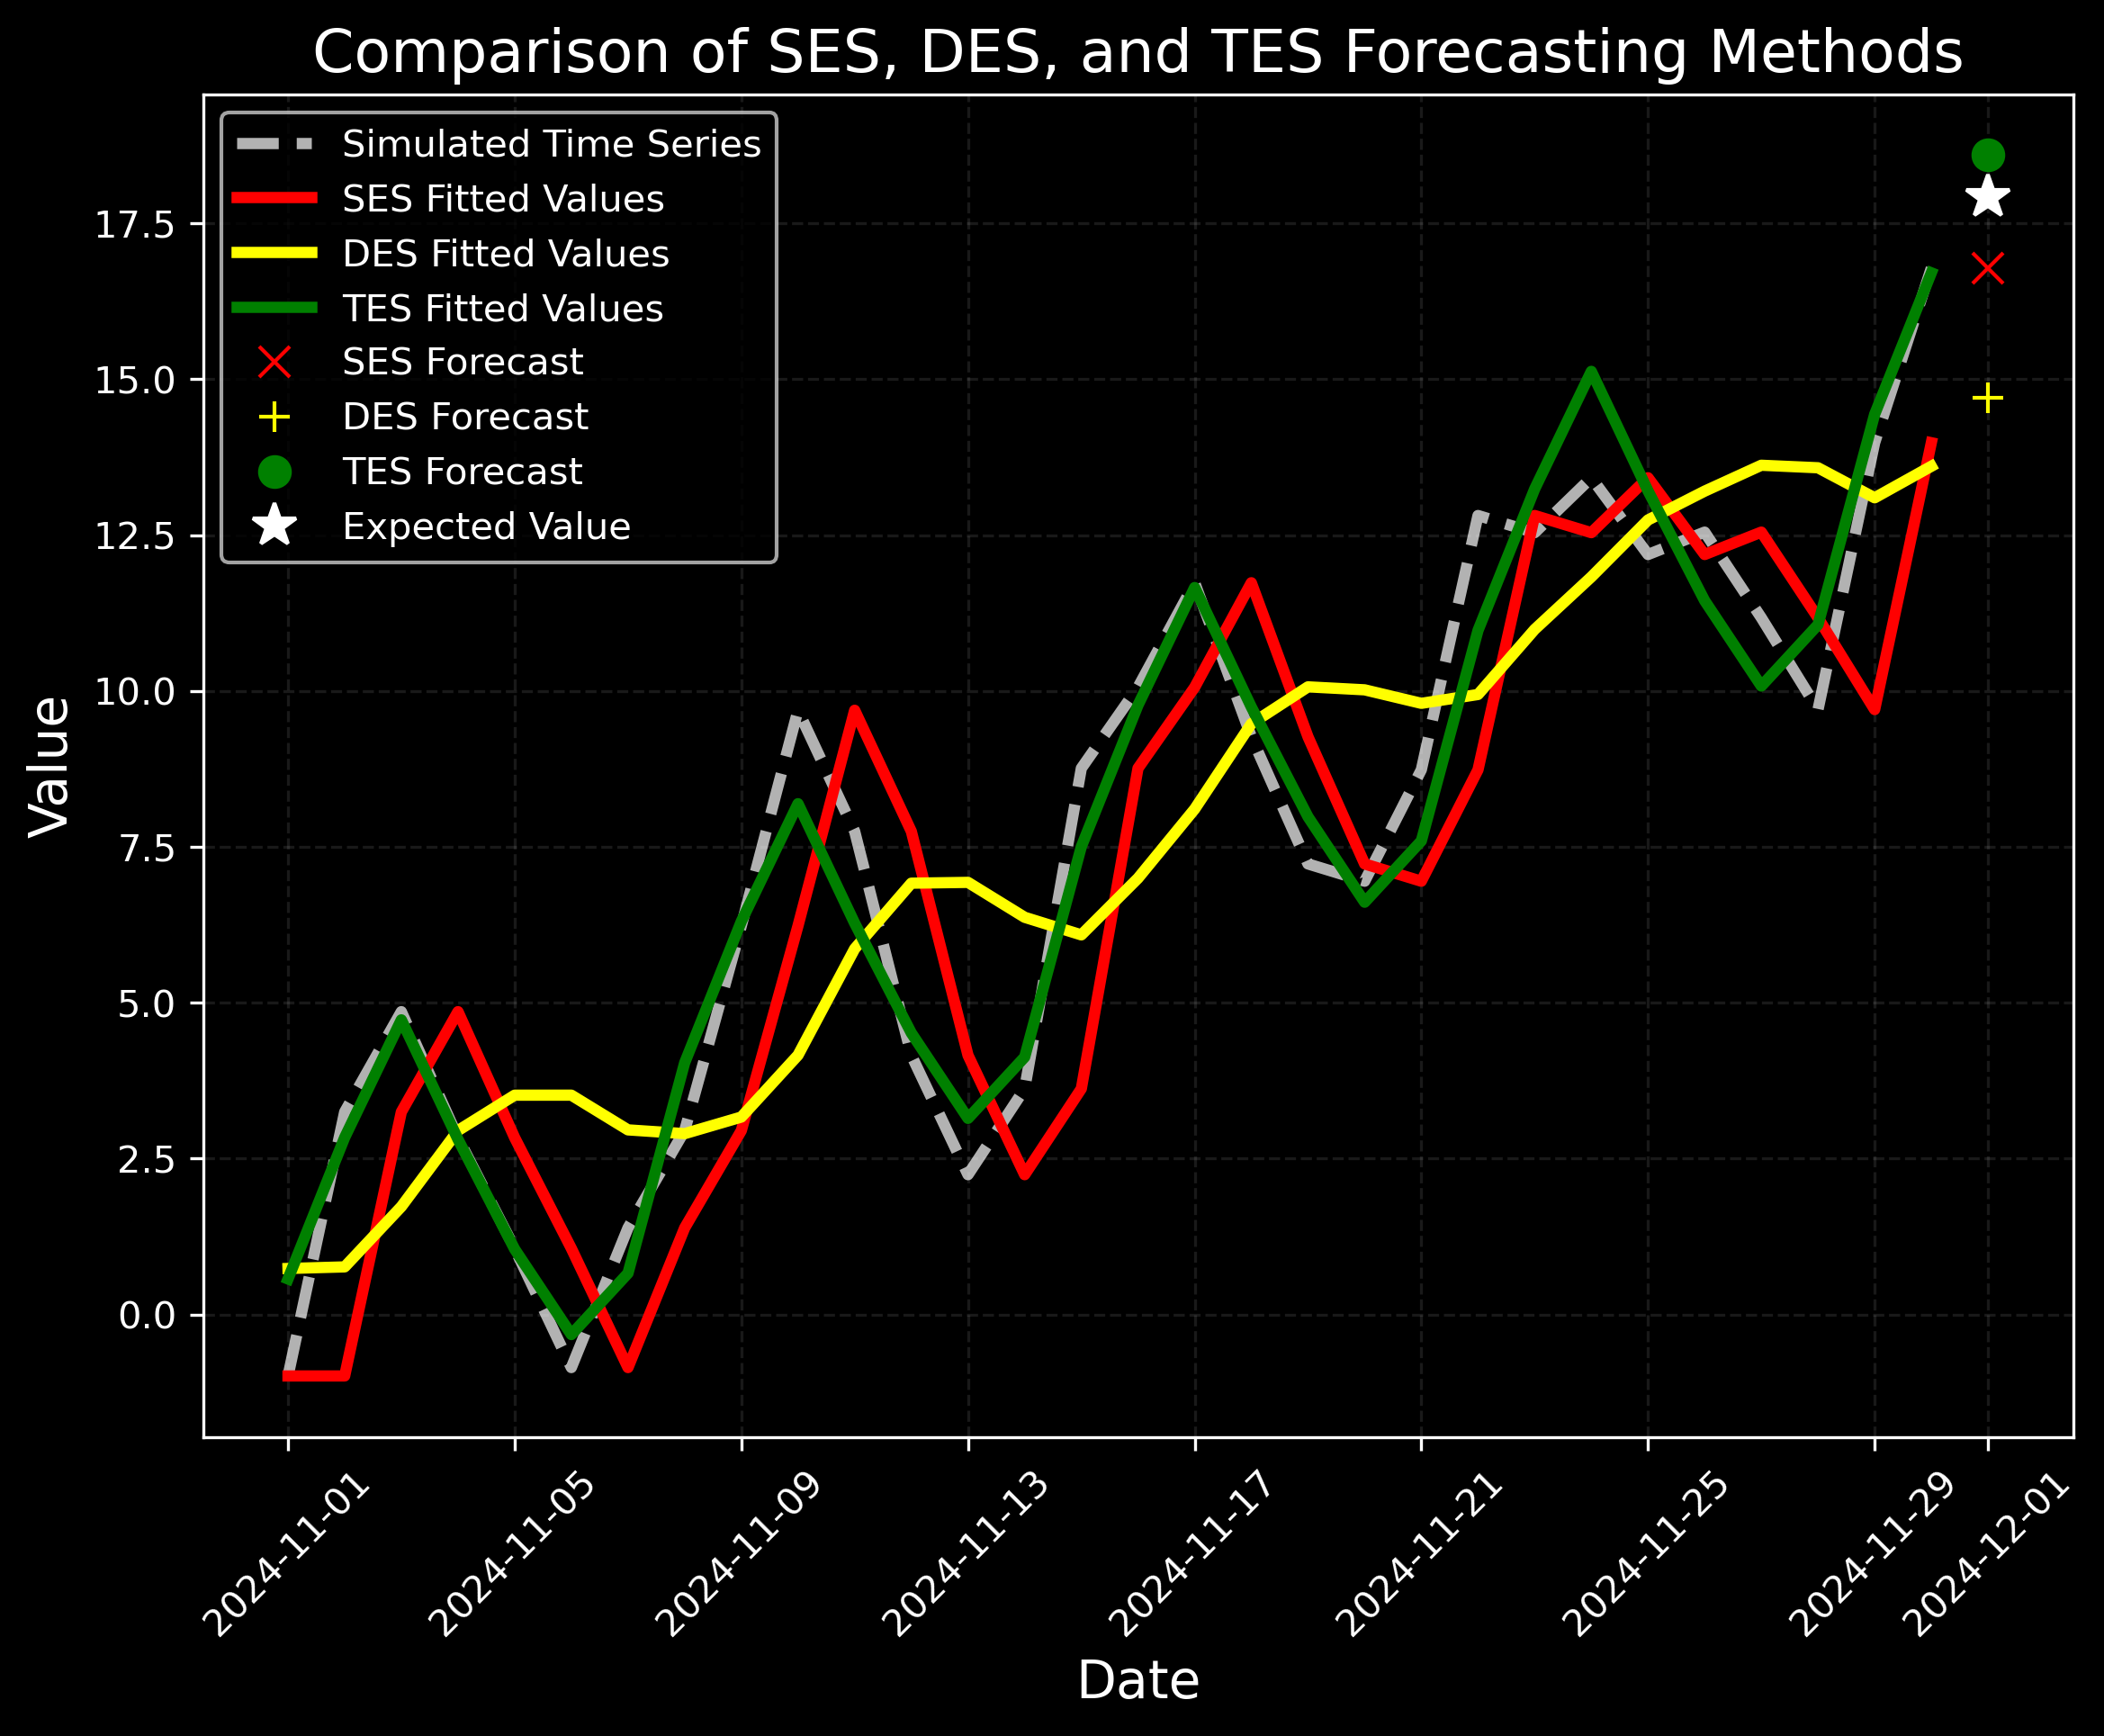

In [4]:
# Fit Single Exponential Smoothing (SES)
ses_fit = ExponentialSmoothing(df['value']).fit()

# Fit Double Exponential Smoothing (DES)
des_fit = ExponentialSmoothing(
    df['value'], trend='add', seasonal=None
).fit(smoothing_level=0.2, smoothing_trend=0.2)  # just for demo

# Fit Triple Exponential Smoothing (TES)
tes_fit = ExponentialSmoothing(
    df['value'], trend='add', 
    seasonal='add', seasonal_periods=periods
).fit()

# Get fitted values from each model
ses_fitted, des_fitted, tes_fitted = (
    ses_fit.fittedvalues,
    des_fit.fittedvalues,
    tes_fit.fittedvalues
)

# Forecast the next value after the last point
ses_forecast, des_forecast, tes_forecast = (
    ses_fit.forecast(steps=1),
    des_fit.forecast(steps=1),
    tes_fit.forecast(steps=1)
)

# Define forecast date
forecast_date = df['date'].iloc[-1] + pd.Timedelta(days=1)

# Calculate the expected value for the next timestamp (no noise)
expected_next_value = (
    trend_slope * n +
    seasonality_amplitude * np.sin(2 * np.pi * n / periods)
)

# Create forecast dataframe with only the forecasted values
forecast_df = pd.DataFrame({
    'date': [forecast_date],
    'SES': ses_forecast,
    'DES': des_forecast,
    'TES': tes_forecast,
    'Expected value': expected_next_value  # Adding expected value for next timestamp
})

# Plotting the generated time series and the fitted values from each model
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(df['date'], df['value'], label="Simulated Time Series", color='white', alpha=0.7, linestyle='--', linewidth=3)
plt.plot(df['date'], ses_fitted, label="SES Fitted Values", color='red', linewidth=3)
plt.plot(df['date'], des_fitted, label="DES Fitted Values", color='yellow', linewidth=3)
plt.plot(df['date'], tes_fitted, label="TES Fitted Values", color='green', linewidth=3)

# Plotting the forecast points as markers directly on the lines (+ for prediction)
plt.plot(forecast_df['date'], forecast_df['SES'], 'x', color='red', label="SES Forecast", markersize=8)
plt.plot(forecast_df['date'], forecast_df['DES'], '+', color='yellow', label="DES Forecast", markersize=8)
plt.plot(forecast_df['date'], forecast_df['TES'], 'o', color='green', label="TES Forecast", markersize=8)

# Marking the expected value (without noise) for the next timestamp
plt.plot(forecast_df['date'], forecast_df['Expected value'], '*', color='white', markersize=12, label="Expected Value")
# Customize the plot
plt.title("Comparison of SES, DES, and TES Forecasting Methods", 
          fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.1)
plt.tight_layout(); plt.xticks(rotation=45)
plt.show()

## Conclusion:
As you can see TES method fits the timeseries the best as expected because TES is the only method that can capture seasonality out of the three methods.
It forecasts the closet to the expected value on Dec 1st, 2024